# Angle of Arrival Estimation

In [1]:
from tqdm.auto import tqdm
import espargos_0007
import cluster_utils
import numpy as np
import CRAP
import os

2025-04-10 13:55:37.687226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 13:55:37.707785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 13:55:37.714371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 13:55:37.729945: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 13:55:38.714024: W tensorflow/compiler/tf2

### Load Datasets and Clutter Channel Estimates

We only want to evaluate the angle of arrival (AoA) estimates of the test sets in this notebook.
But since we also need the AoA estimates of the training sets in the subsequent notebooks, we will calculate them here as well.

In [2]:
# Loading all the datasets can take some time...
training_set_robot = espargos_0007.load_dataset(espargos_0007.TRAINING_SET_ROBOT_FILES)
test_set_robot = espargos_0007.load_dataset(espargos_0007.TEST_SET_ROBOT_FILES)
test_set_human = espargos_0007.load_dataset(espargos_0007.TEST_SET_HUMAN_FILES)

all_datasets = training_set_robot + test_set_robot + test_set_human

  0%|          | 0/3 [00:00<?, ?it/s]

Loading espargos-0007/espargos-0007-meanders-nw-se-1.tfrecords


I0000 00:00:1744293346.070353   27732 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744293346.133342   27732 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744293346.133722   27732 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744293346.136697   27732 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Loading espargos-0007/espargos-0007-meanders-sw-ne-1.tfrecords


2025-04-10 13:56:08.942585: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loading espargos-0007/espargos-0007-randomwalk-1.tfrecords


  0%|          | 0/1 [00:00<?, ?it/s]

Loading espargos-0007/espargos-0007-randomwalk-2.tfrecords


2025-04-10 13:56:23.639346: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/1 [00:00<?, ?it/s]

Loading espargos-0007/espargos-0007-human-helmet-randomwalk-1.tfrecords


In [3]:
for dataset in all_datasets:
    dataset["clutter_acquisitions"] = np.load(os.path.join("clutter_channel_estimates", os.path.basename(dataset["filename"]) + ".npy"))

In [4]:
for dataset in all_datasets:
    cluster_utils.cluster_dataset(dataset)

Clustering dataset espargos-0007/espargos-0007-meanders-nw-se-1.tfrecords


  0%|          | 0/174647 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-meanders-sw-ne-1.tfrecords


  0%|          | 0/204711 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-randomwalk-1.tfrecords


  0%|          | 0/103524 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-randomwalk-2.tfrecords


  0%|          | 0/139427 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-human-helmet-randomwalk-1.tfrecords


  0%|          | 0/33011 [00:00<?, ?it/s]

### Perform AoA Estimation (Unitary Root Music Algorithm)

In [5]:
def get_unitary_rootmusic_estimator(chunksize = 32, shed_coeff_ratio = 0):
    I = np.eye(chunksize // 2)
    J = np.flip(np.eye(chunksize // 2), axis = -1)
    Q = np.asmatrix(np.block([[I, 1.0j * I], [J, -1.0j * J]]) / np.sqrt(2))
    
    def unitary_rootmusic(R):
        assert(len(R) == chunksize)
        C = np.real(Q.H @ R @ Q)
    
        eig_val, eig_vec = np.linalg.eigh(C)
        eig_val = eig_val[::-1]
        eig_vec = eig_vec[:,::-1]

        source_count = 1
        En = eig_vec[:,source_count:]
        ENSQ = Q @ En @ En.T @ Q.H
    
        coeffs = np.asarray([np.trace(ENSQ, offset = diag) for diag in range(1, len(R))])
        coeffs = coeffs[:int(len(coeffs) * (1 - shed_coeff_ratio))]

        # Remove some of the smaller noise coefficients, trade accuracy for speed
        coeffs = np.hstack((coeffs[::-1], np.trace(ENSQ), coeffs.conj()))
        roots = np.roots(coeffs)
        roots = roots[abs(roots) < 1.0]
        largest_root = np.argmax(1 / (1.0 - np.abs(roots)))
        
        return np.angle(roots[largest_root]), np.abs(roots[largest_root])

    return unitary_rootmusic

umusic = get_unitary_rootmusic_estimator(4)

In [6]:
for dataset in tqdm(all_datasets):
    print(f"AoA estimation for dataset: {dataset["filename"]}")

    dataset["cluster_aoa_angles"] = []
    dataset["cluster_aoa_powers"] = []

    for cluster in tqdm(dataset["clusters"]):
        csi_by_transmitter_noclutter = []
        for tx_idx, csi in enumerate(cluster["csi_freq_domain"]):
            csi_by_transmitter_noclutter.append(CRAP.remove_clutter(csi, dataset["clutter_acquisitions"][tx_idx]))

        R = np.zeros((espargos_0007.ARRAY_COUNT, espargos_0007.COL_COUNT, espargos_0007.COL_COUNT), dtype = np.complex64)

        for tx_csi in csi_by_transmitter_noclutter:
            R = R + np.einsum("dbrms,dbrns->bmn", tx_csi, np.conj(tx_csi)) / tx_csi.shape[0]

        music_results = [umusic(R[array]) for array in range(R.shape[0])]
        dataset["cluster_aoa_angles"].append(np.asarray([np.arcsin(angle_power[0] / np.pi) for angle_power in music_results]))
        dataset["cluster_aoa_powers"].append(np.asarray([angle_power[1] for angle_power in music_results]))

    dataset["cluster_aoa_angles"] = np.asarray(dataset["cluster_aoa_angles"])
    dataset["cluster_aoa_powers"] = np.asarray(dataset["cluster_aoa_powers"])

  0%|          | 0/5 [00:00<?, ?it/s]

AoA estimation for dataset: espargos-0007/espargos-0007-meanders-nw-se-1.tfrecords


  0%|          | 0/2860 [00:00<?, ?it/s]

AoA estimation for dataset: espargos-0007/espargos-0007-meanders-sw-ne-1.tfrecords


  0%|          | 0/3468 [00:00<?, ?it/s]

AoA estimation for dataset: espargos-0007/espargos-0007-randomwalk-1.tfrecords


  0%|          | 0/1684 [00:00<?, ?it/s]

AoA estimation for dataset: espargos-0007/espargos-0007-randomwalk-2.tfrecords


  0%|          | 0/2337 [00:00<?, ?it/s]

AoA estimation for dataset: espargos-0007/espargos-0007-human-helmet-randomwalk-1.tfrecords


  0%|          | 0/556 [00:00<?, ?it/s]

### Store AoA Estimation Results to File

In [7]:
!mkdir -p aoa_estimates
for dataset in all_datasets:
    dataset_name = os.path.basename(dataset["filename"])
    np.save(os.path.join("aoa_estimates", dataset_name + ".aoa_angles.npy"), np.asarray(dataset["cluster_aoa_angles"]))
    np.save(os.path.join("aoa_estimates", dataset_name + ".aoa_powers.npy"), np.asarray(dataset["cluster_aoa_powers"]))

### Optional: Plot Results

In [8]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

  0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_6733/1928125160.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


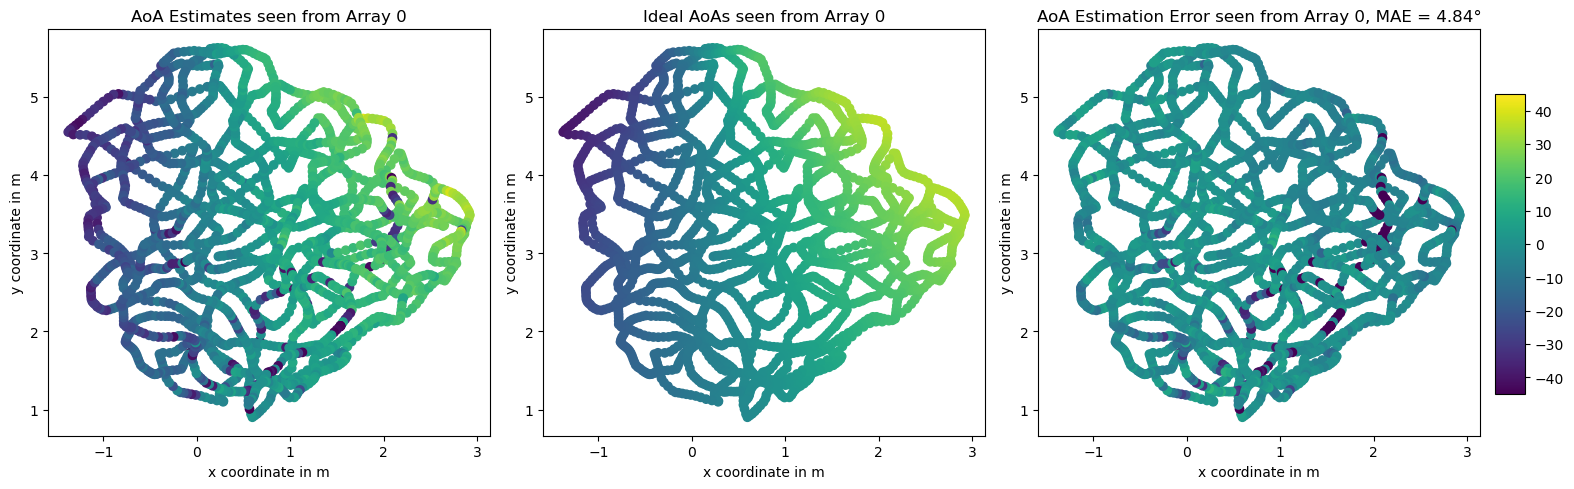

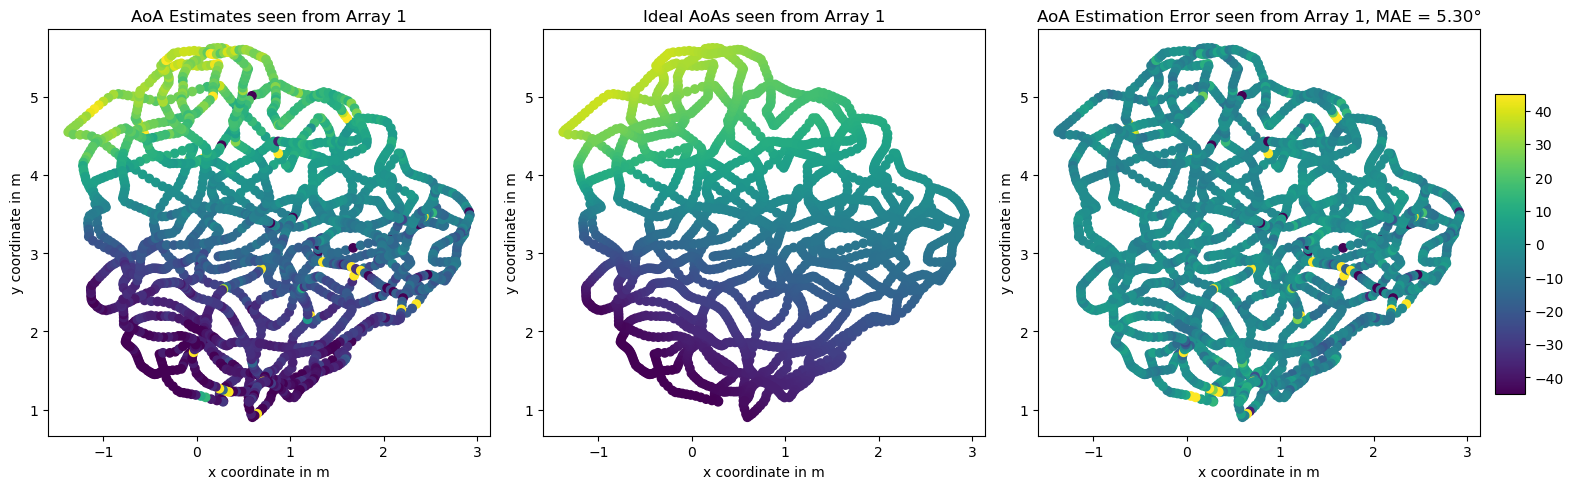

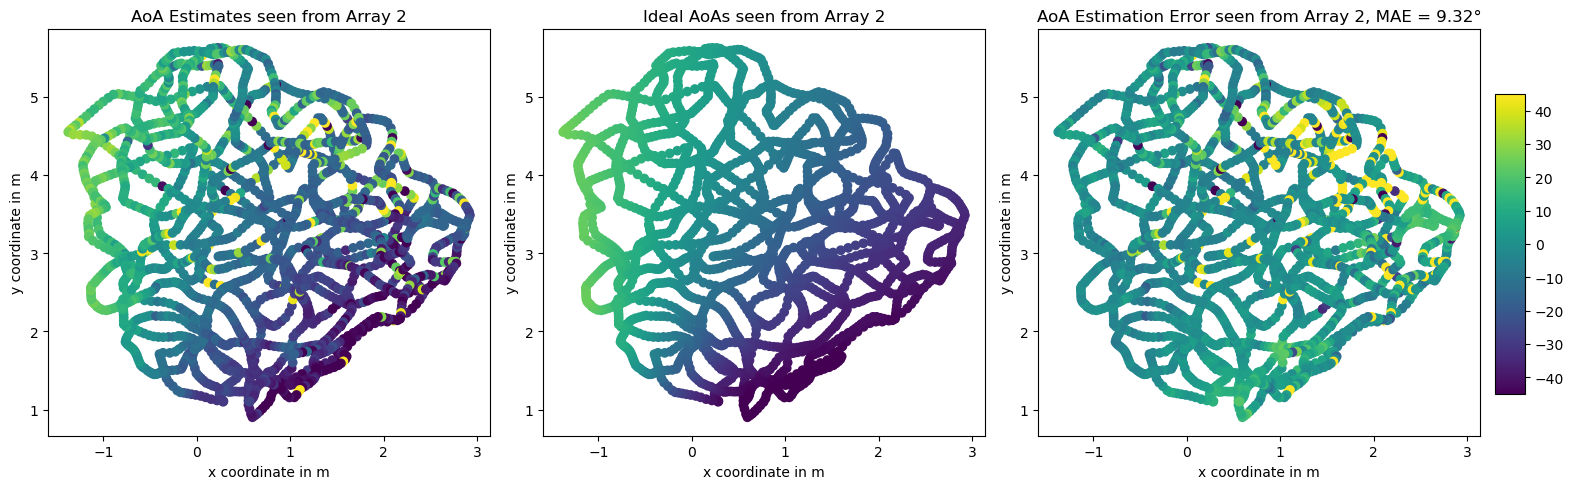

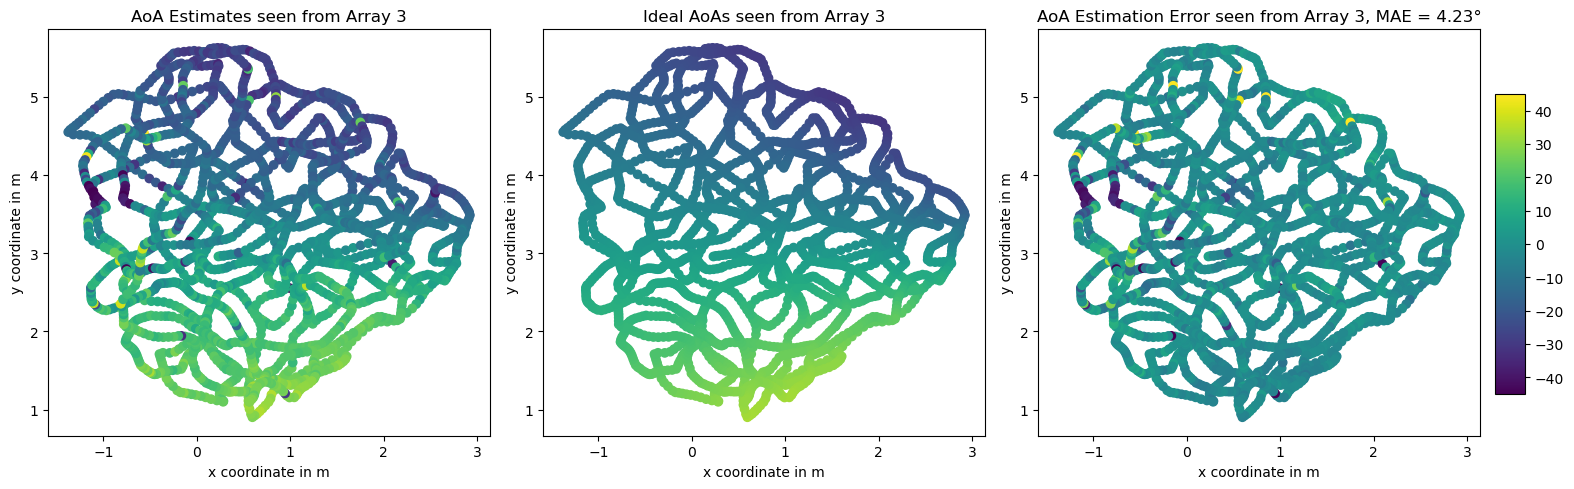

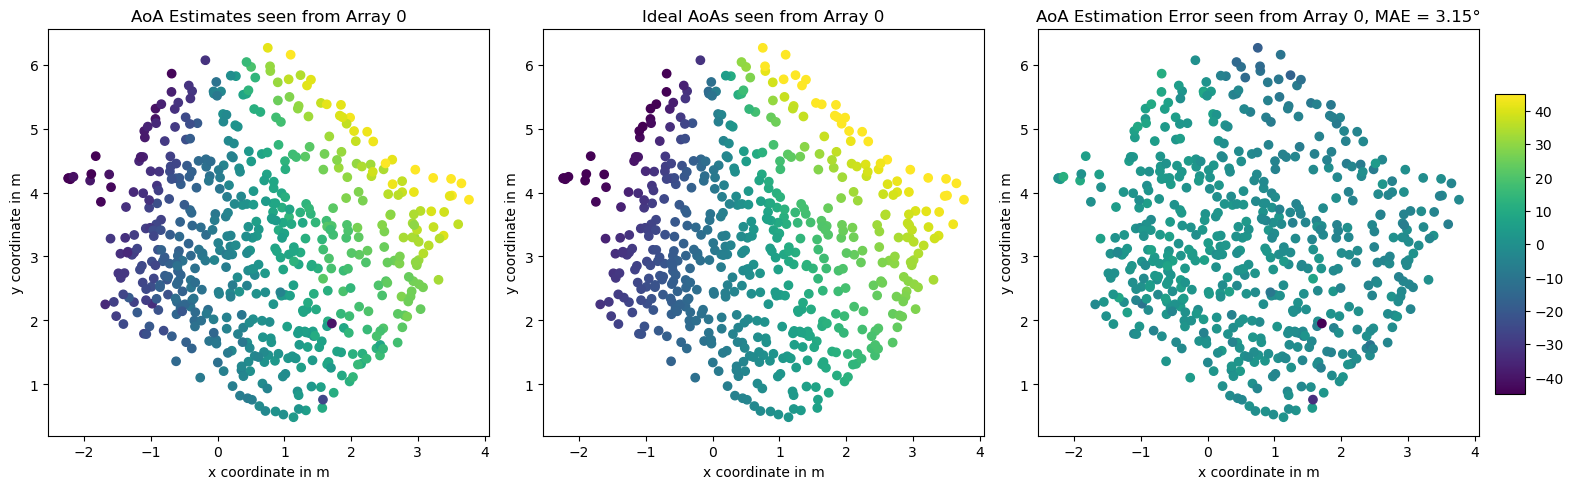

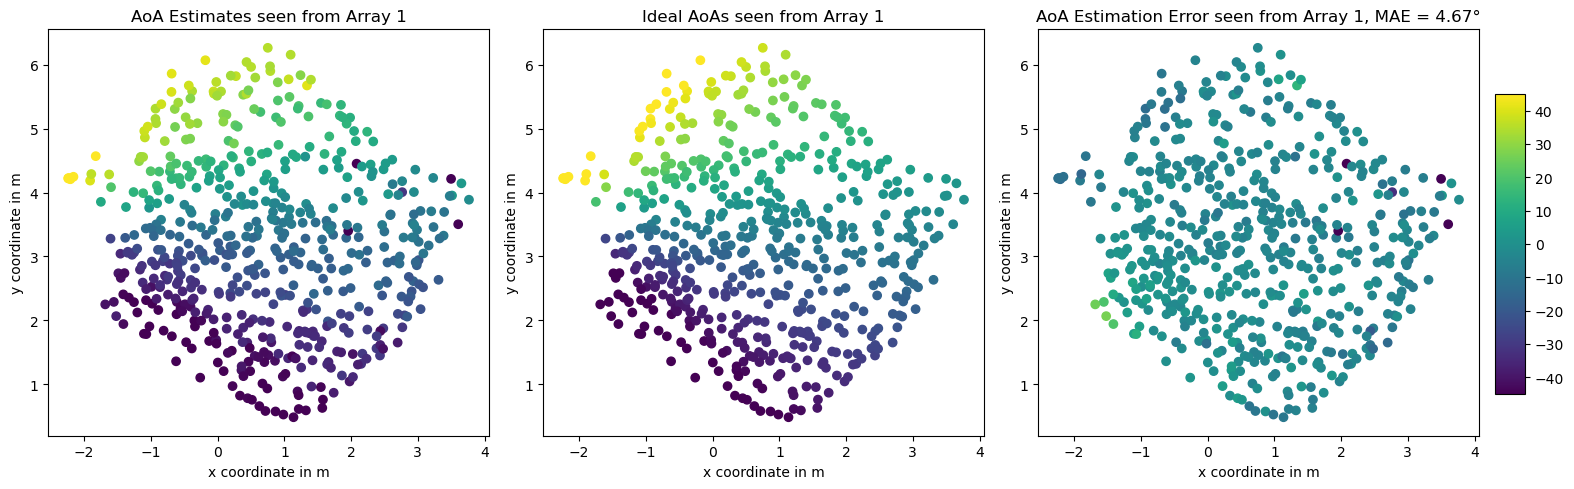

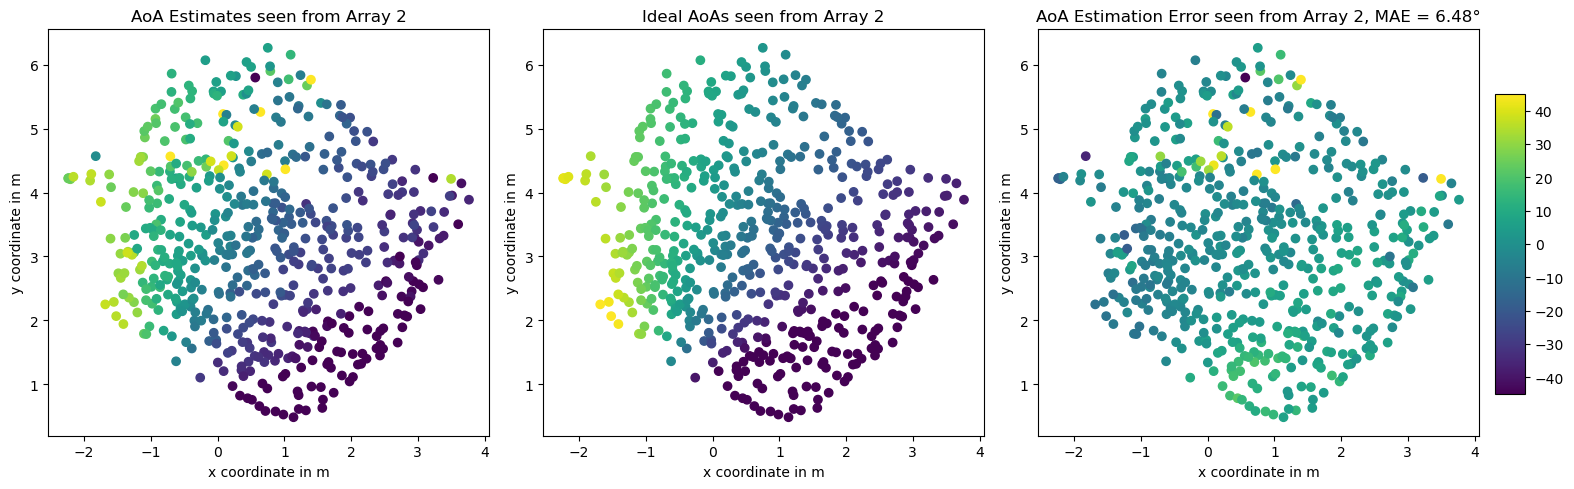

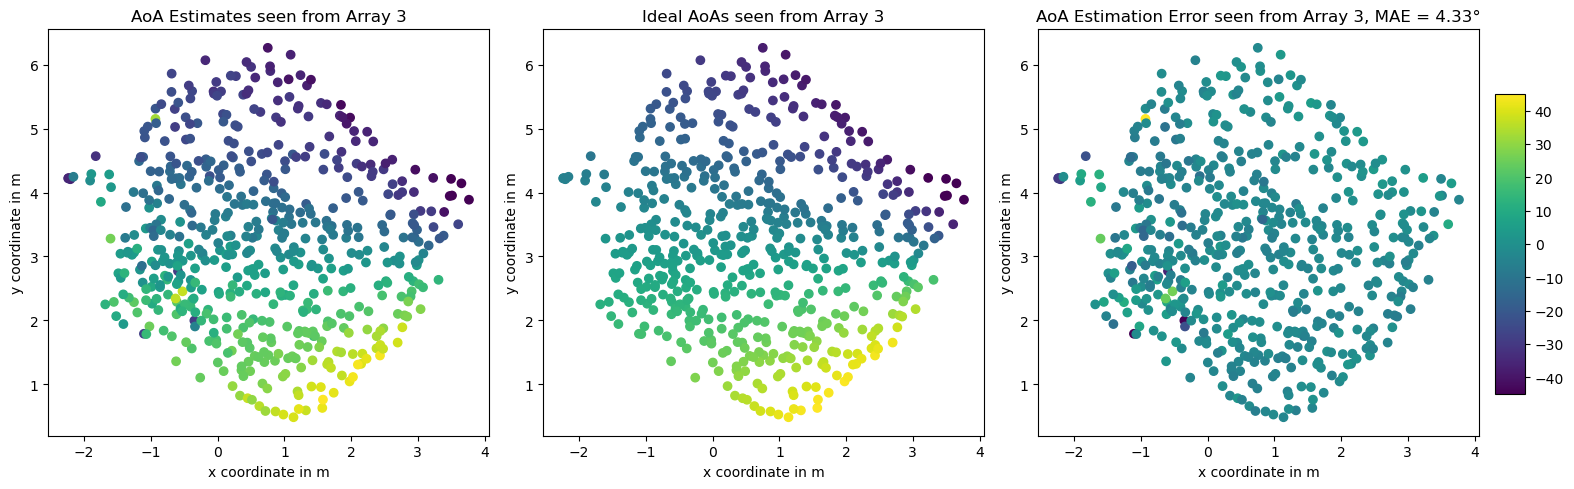

In [9]:
for dataset in tqdm(test_set_robot + test_set_human):
    # Compute expected AoA for position
    relative_pos = dataset["cluster_positions"][:,np.newaxis,:] - espargos_0007.array_positions
    normal = np.einsum("dax,ax->da", relative_pos, espargos_0007.array_normalvectors)
    right = np.einsum("dax,ax->da", relative_pos, espargos_0007.array_rightvectors)
    up = np.einsum("dax,ax->da", relative_pos, espargos_0007.array_upvectors)
    ideal_aoas = np.arctan2(right, normal)
    ideal_eles = -np.arctan2(up, normal)

    dataset["cluster_groundtruth_aoas"] = ideal_aoas
    dataset["cluster_aoa_estimation_errors"] = dataset["cluster_aoa_angles"] - dataset["cluster_groundtruth_aoas"]

    norm = mcolors.Normalize(vmin=-45, vmax=45)
    for b in range(dataset["cluster_aoa_angles"].shape[1]):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Estimated AoAs
        im1 = axes[0].scatter(dataset["cluster_positions"][:,0], dataset["cluster_positions"][:,1], c = np.rad2deg(dataset["cluster_aoa_angles"][:,b]), norm = norm)
        axes[0].set_title(f"AoA Estimates seen from Array {b}")
        axes[0].set_xlabel("x coordinate in m")
        axes[0].set_ylabel("y coordinate in m")

        # Ideal AoAs
        im2 = axes[1].scatter(dataset["cluster_positions"][:,0], dataset["cluster_positions"][:,1], c = np.rad2deg(dataset["cluster_groundtruth_aoas"][:,b]), norm = norm)
        axes[1].set_title(f"Ideal AoAs seen from Array {b}")
        axes[1].set_xlabel("x coordinate in m")
        axes[1].set_ylabel("y coordinate in m")

        # AoA Errors
        im2 = axes[2].scatter(dataset["cluster_positions"][:,0], dataset["cluster_positions"][:,1], c = np.rad2deg(dataset["cluster_aoa_estimation_errors"][:,b]), norm = norm)
        axes[2].set_title(f"AoA Estimation Error seen from Array {b}, MAE = {np.mean(np.abs(np.rad2deg(dataset["cluster_aoa_estimation_errors"][:,b]))):.2f}°")
        axes[2].set_xlabel("x coordinate in m")
        axes[2].set_ylabel("y coordinate in m")
        
        cbar_ax = fig.add_axes([1.00, 0.2, 0.02, 0.6])
        fig.colorbar(im1, cax=cbar_ax)
        plt.tight_layout()
        plt.show()